In [2]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [3]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

# S0235b

In [4]:
begin = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples
XB.ELYSE.02.BHN | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples
XB.ELYSE.02.BHZ | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples

In [6]:
stP = stf.slice(starttime=begin-1,endtime=begin+2)
stS = stf.slice(starttime=end-2, endtime=end+15)

In [ ]:
#error calculation, noise estimation
stP2 = stf.slice(starttime=begin-10,endtime=begin+10)
stS2 = stf.slice(starttime=end-10, endtime=end+10)
stP2.plot();
stS2.plot();

In [7]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data
array1 = np.array([Pamp, Pamp])
array2 = np.array([Svamp, SVamp])

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_74 = tval[np.where(alpha == 74)]
print(mina_74, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported as 74

[ 0.08934134] [ 0.08880175]
optimal angle =  72  or  -108


In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,252)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0173a

In [18]:
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)
    
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHN | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:22:56.981000Z - 2019-05-23T02:23:00.981000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-05-23T02:22:56.981000Z - 2019-05-23T02:23:00.981000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:22:56.981000Z - 2019-05-23T02:23:00.981000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:25:50.981000Z - 2019-05-23T02:25:54.981000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-05-23T02:25:50.981000Z - 2019-05-23T02:25:54.981000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:25:50.981000Z - 2019-05-23T02:25:54.981000Z | 20.0 Hz, 81 samples


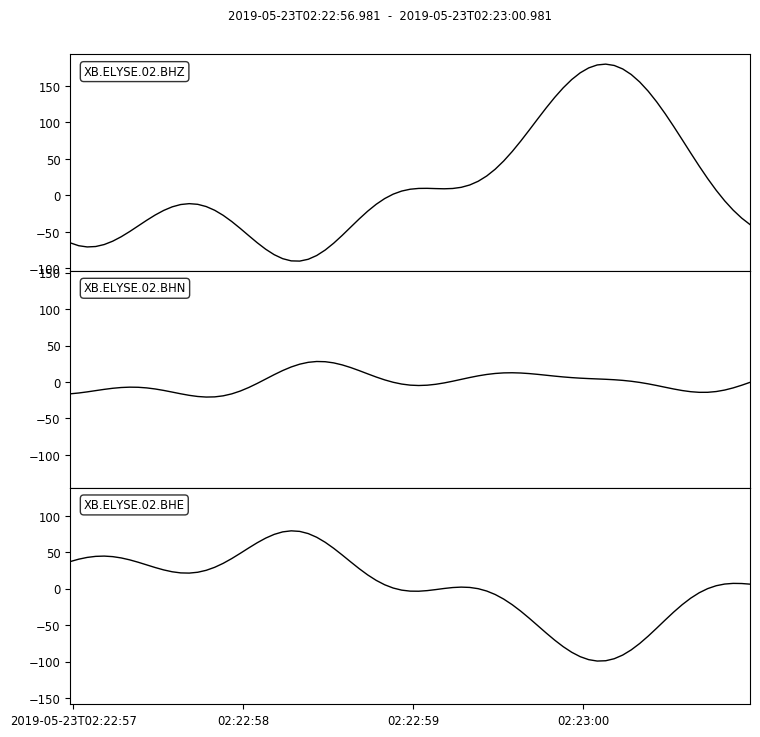

In [19]:
stP = stf.slice(starttime=begin-2,endtime=begin+2)
stS = stf.slice(starttime=end-2, endtime=end+2)
print(stP)
print(stS)
stP.plot();

In [ ]:
#error calculation, noise estimation
stP2 = stf.slice(starttime=begin-10,endtime=begin+10)
stS2 = stf.slice(starttime=end-10, endtime=end+10)

stP2.plot();
stS2.plot();

In [20]:
scale = 1/400
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_91 = tval[np.where(alpha == 91)]
print(mina_91, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

print(tval)

#reported 91 degrees

[ 0.08057868] [ 0.08010093]
optimal angle =  90  or  -90
[ 1.20639448  1.20591673  1.20475345  1.20290606  1.20037682  1.1971688
  1.19328591  1.18873289  1.18351527  1.17763943  1.17111251  1.16394246
  1.15613803  1.14770873  1.13866481  1.12901731  1.11877797  1.10795926
  1.09657438  1.0846372   1.07216224  1.05916472  1.04566047  1.03166594
  1.01719819  1.00227483  0.98691405  0.97113457  0.95495561  0.93839688
  0.92147856  0.90422125  0.88664599  0.86877419  0.85062761  0.83222838
  0.8135989   0.79476188  0.77574026  0.75655722  0.73723612  0.71780052
  0.69827408  0.67868061  0.65904396  0.63938807  0.61973689  0.60011434
  0.58054435  0.56105075  0.5416573   0.52238762  0.50326519  0.4843133
  0.46555505  0.4470133   0.42871062  0.41066933  0.39291139  0.37545845
  0.35833178  0.34155223  0.32514024  0.30911583  0.2934985   0.27830728
  0.26356069  0.2492767   0.23547269  0.22216549  0.20937132  0.19710576
  0.18538376  0.17421959  0.16362686  0.15361847  0.14420663  0.13540

In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,266)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0173ab

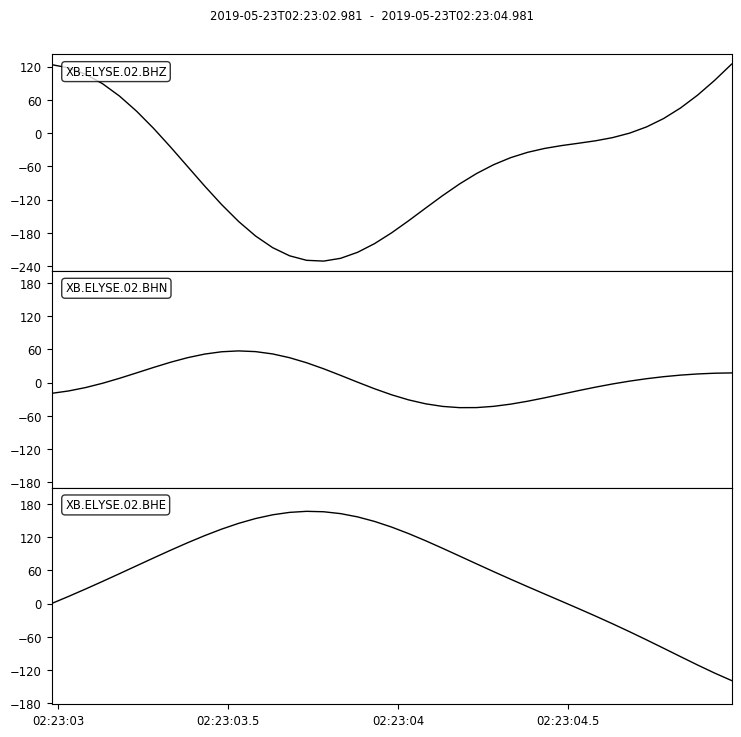

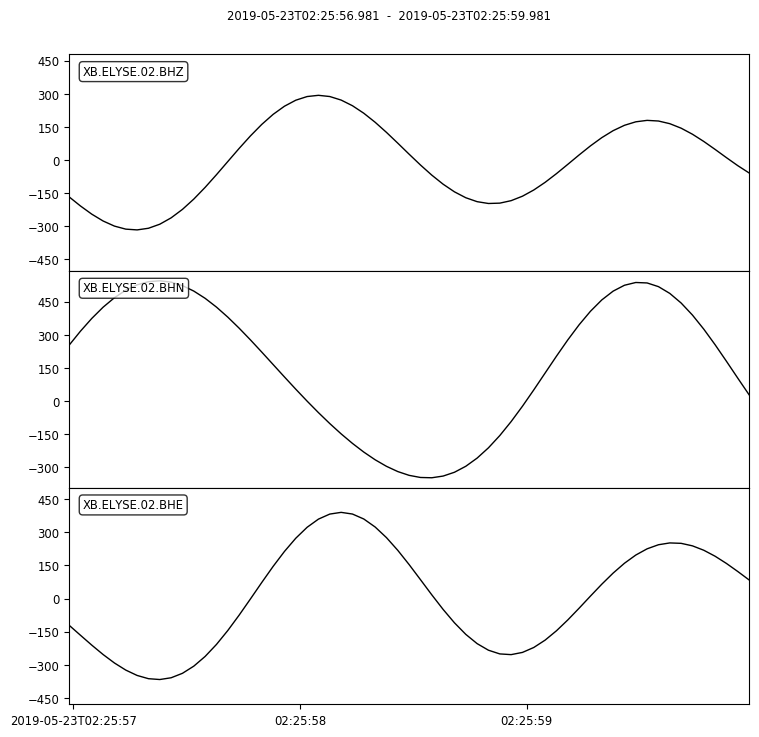

In [15]:
stP2 = stf.slice(starttime=begin+4,endtime=begin+6)
stS2 = stf.slice(starttime=end+4, endtime=end+7)

stP2.plot();
stS2.plot();

In [17]:
scale = 1/400
hhe = scale * stP2[0].data
hhn = scale * stP2[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_80 = tval[np.where(alpha == 80)]
print(mina_guess)
print(mina_80)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)


[ 0.2357776]
[ 0.25975746]
optimal angle =  86  or  -94


In [ ]:
hhe = stS2[0].data
hhn = stS2[1].data
hhT,hhR = rotate(hhe,hhn,266)

streamRT = stS2.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0325a

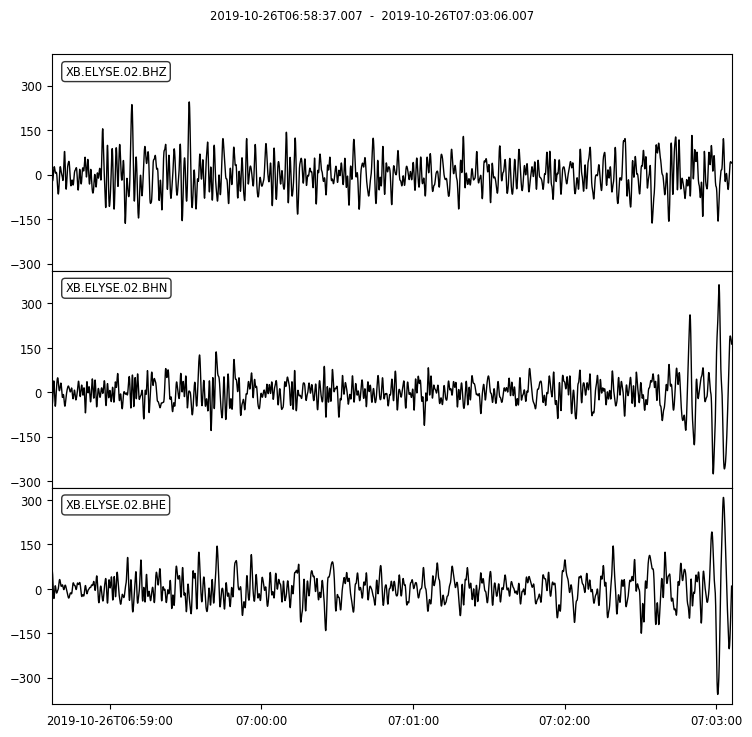

In [21]:
begin = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=begin-20, endtime=end+20)
stzoom.plot();

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:44.007000Z - 2019-10-26T07:02:51.007000Z | 20.0 Hz, 141 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:44.007000Z - 2019-10-26T07:02:51.007000Z | 20.0 Hz, 141 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:44.007000Z - 2019-10-26T07:02:51.007000Z | 20.0 Hz, 141 samples


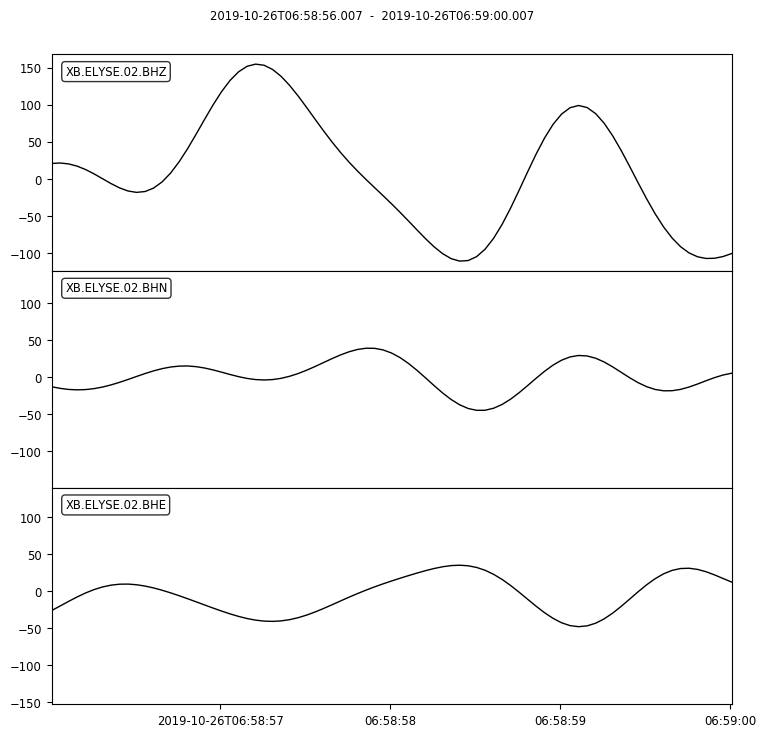

In [22]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-2, endtime=end+5)
print(stP)
print(stS)
stP.plot();

In [ ]:
#error calculation, noise estimation
stP2 = stf.slice(starttime=begin-10,endtime=begin+10)
stS2 = stf.slice(starttime=end-10, endtime=end+10)

stP2.plot();
stS2.plot();

In [23]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_123 = tval[np.where(alpha == 123)]
print(mina_guess)
print(mina_123)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.52475906]
[ 0.52475906]
optimal angle =  303  or  123


In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,303)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0325ab

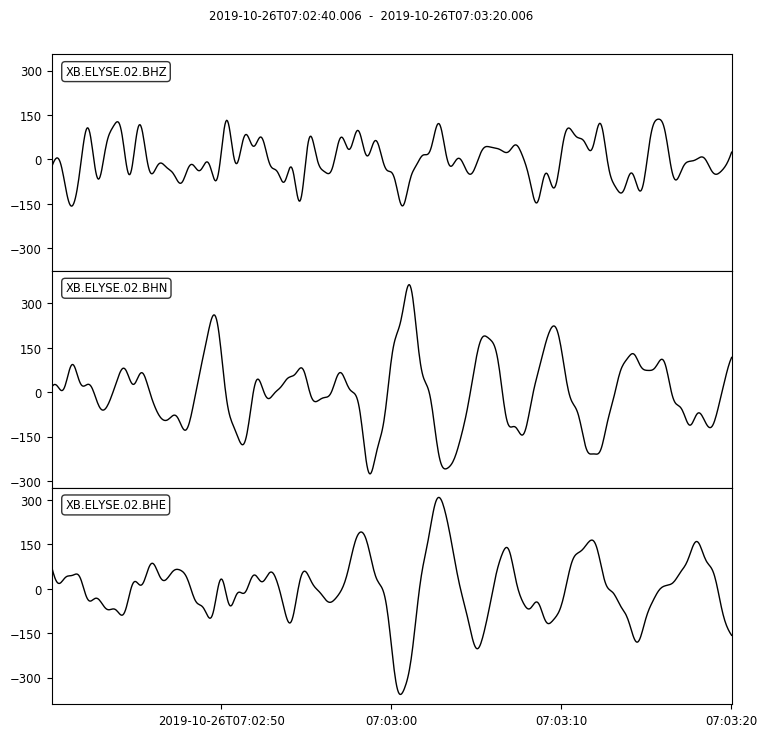

In [24]:
begin = UTCDateTime('2019-10-26T06:59:08')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:03:00')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:59:08.006000Z - 2019-10-26T06:59:09.006000Z | 20.0 Hz, 21 samples
XB.ELYSE.02.BHN | 2019-10-26T06:59:08.006000Z - 2019-10-26T06:59:09.006000Z | 20.0 Hz, 21 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:59:08.006000Z - 2019-10-26T06:59:09.006000Z | 20.0 Hz, 21 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:59.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 321 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:59.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 321 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:59.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 321 samples


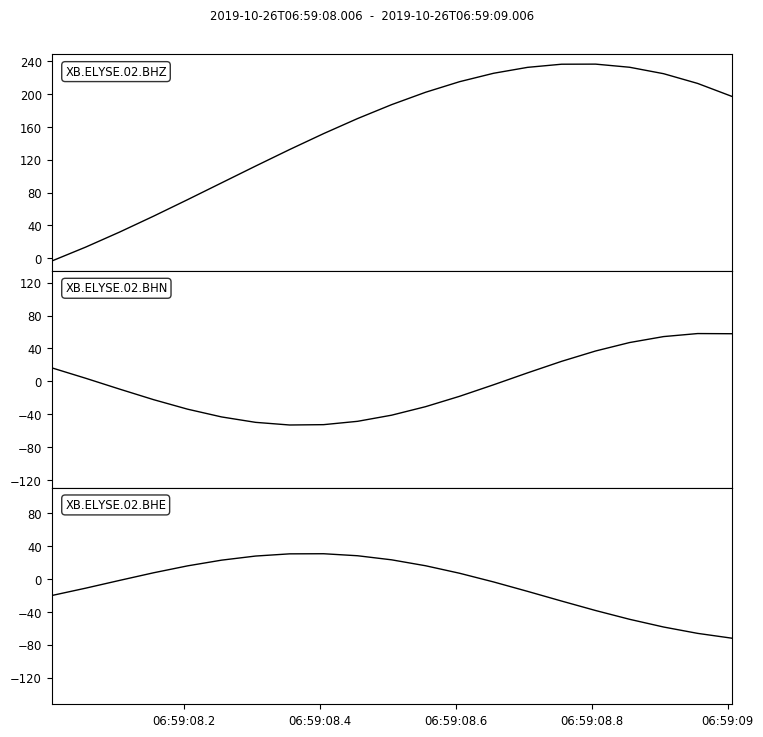

In [25]:
stP = stf.slice(starttime=begin,endtime=begin+1)
stS = stf.slice(starttime=end-1, endtime=end+15)
print(stP)
print(stS)
stP.plot();

In [26]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.04390149]
optimal angle =  139  or  -41


In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,290)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0183a

In [ ]:
begin = UTCDateTime('2019-06-03T02:27:49')  # p-wave arrival
end = UTCDateTime('2019-06-03T02:32:15')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

In [ ]:
%matplotlib notebook
stP = stf.slice(starttime=begin-1,endtime=begin+6)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)
stP.plot()

In [ ]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,285) #rotate to 180+optimal angle calculated above

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();